# Library
---

In [142]:
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from keras import regularizers
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from scipy.stats import f_oneway
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

In [137]:
# preferences for plotting
def set_global_styles():
    sns.set_style({"axes.facecolor": "lightyellow",
                "figure.facecolor": "lightyellow"})
    plt.rcParams['axes.facecolor'] = 'lightyellow'
    plt.rcParams['figure.facecolor'] = 'lightyellow'

set_global_styles()

# Data Exploration

This data consists of a 2 class dataset of fetal health related to fetal cardiotocography (CTG) data. This kind of data is collected during pregnancy to assess the well-being of a fetus by monitoring the fetal heart rate (FHR) and uterine contractions. 

In [105]:
data = pd.read_csv("fetal_data.csv")
data.head()

,Unnamed: 0,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,0.0
1,1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


Since we don't know whether class 0 or 1 represents the healthy or pathological cases, I'll start by examining the class distribution. My assumption is that the more common class likely represents healthy fetal cases.

In [106]:
data.drop(columns="Unnamed: 0", inplace=True)
data['fetal_health'].value_counts()

fetal_health
1.0    1655
0.0     471
Name: count, dtype: int64

In [107]:
data.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,0.778457
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.415383
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,0.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,1.000000


Okay because the data 1 is more common compared to 0, i assume that class 1 is healthy case and 0 is the pathological fetal

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [109]:
data.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [110]:
data.duplicated().sum()

13

We drop duplicated data to avoid overfeeding the model with redundant information that may not contribute to learning. This also helps prevent potential data leakage, especially if duplicates appear in the test set.

In [111]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

# EDA

## Numerical Data Distribution

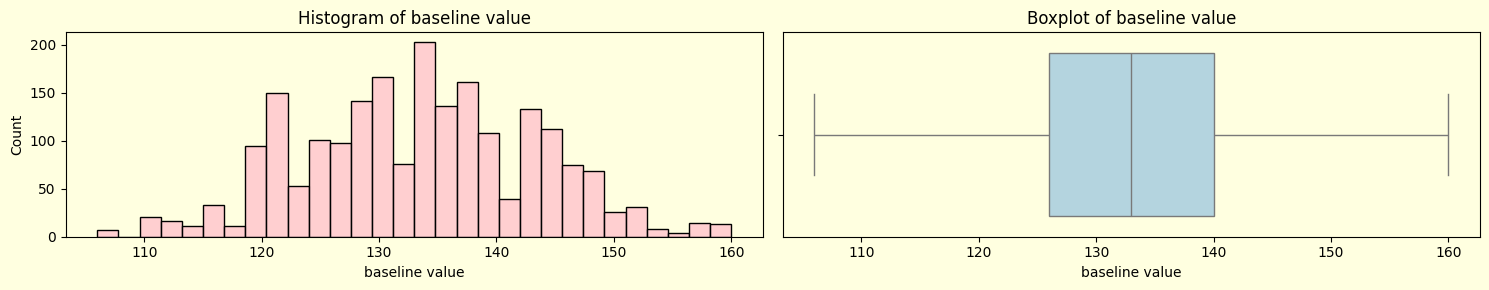

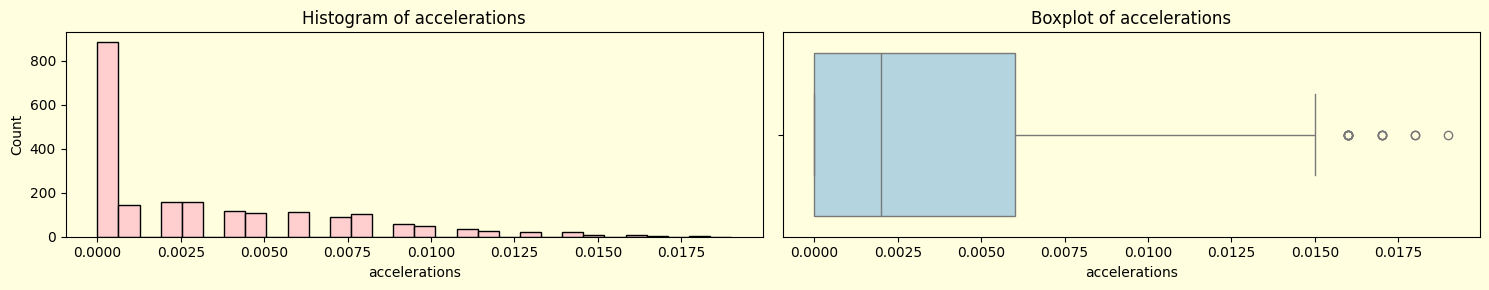

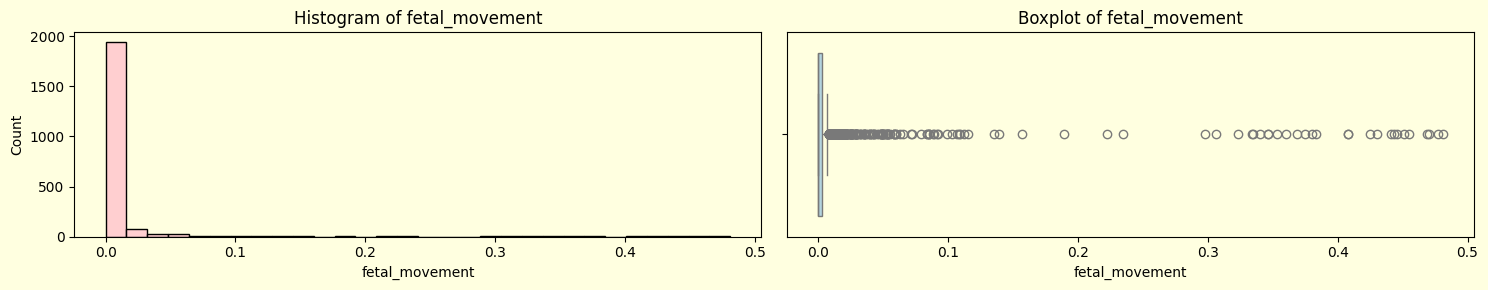

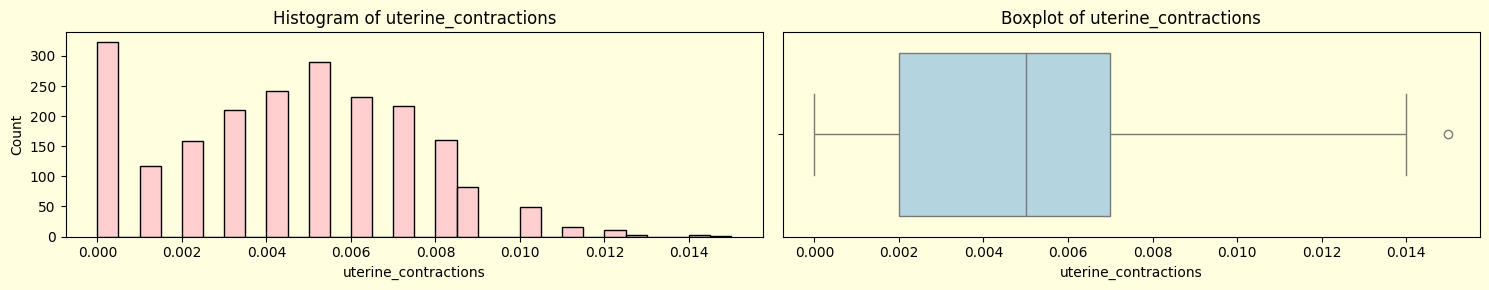

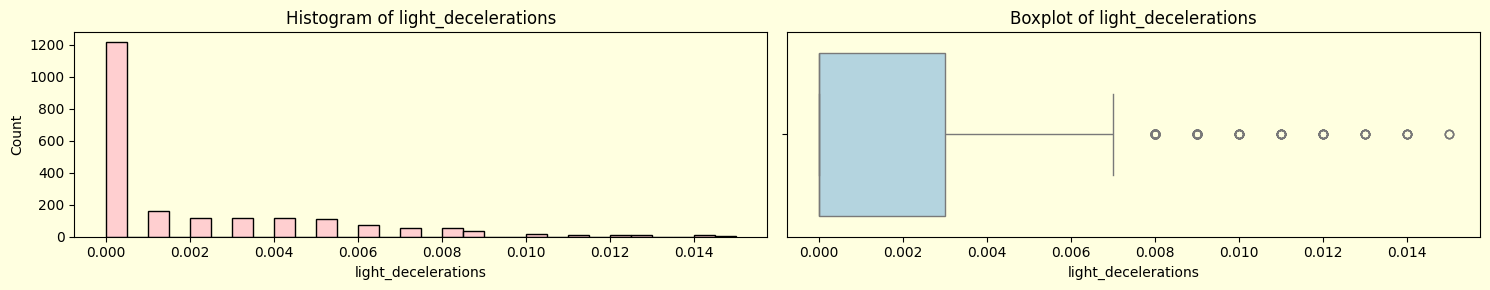

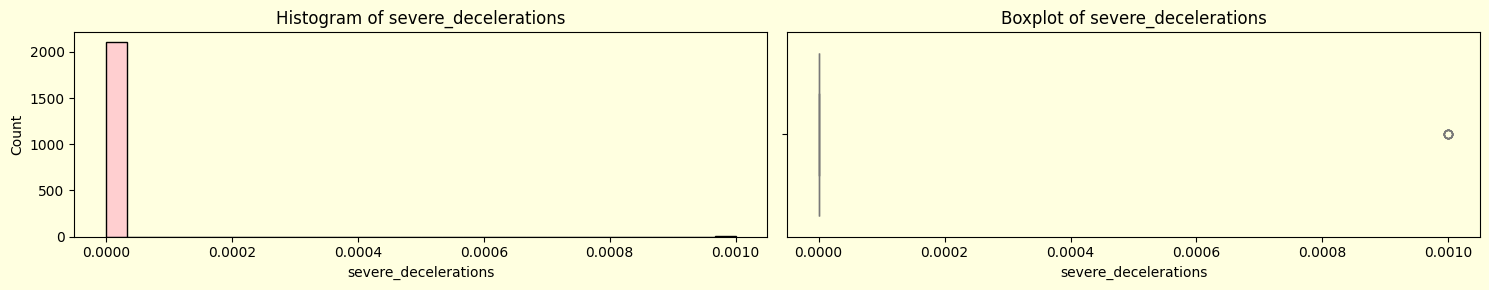

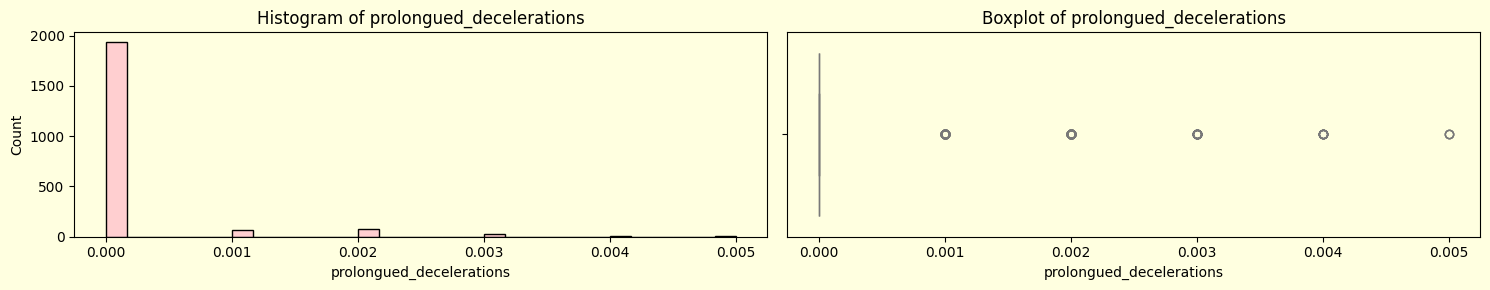

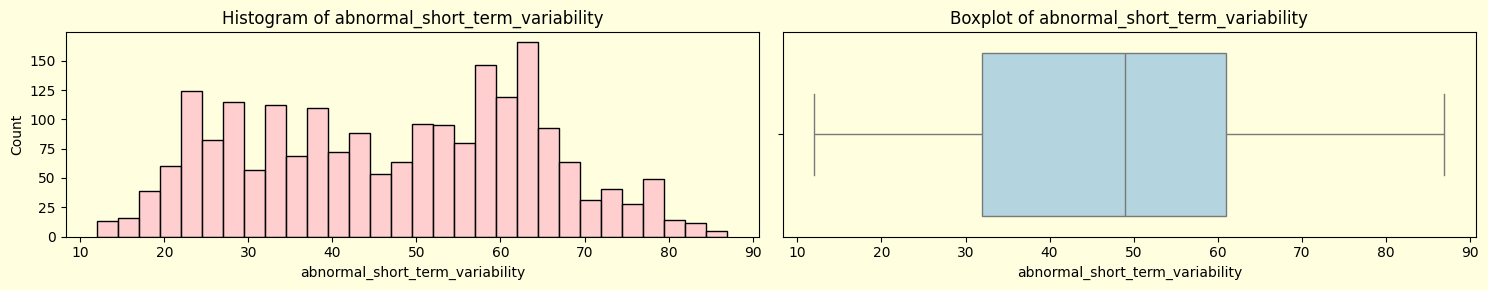

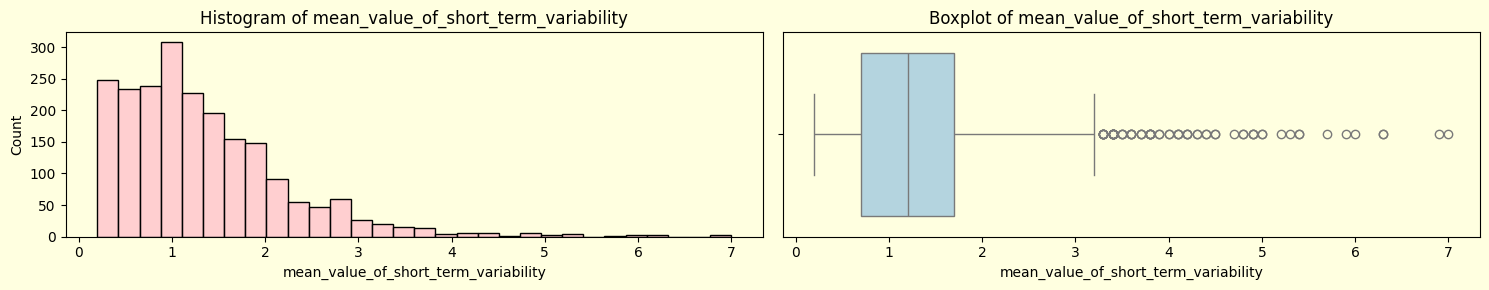

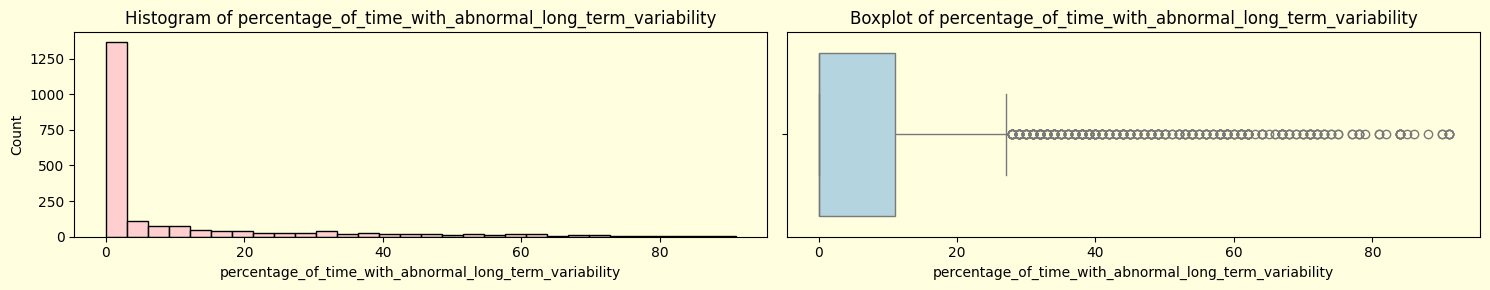

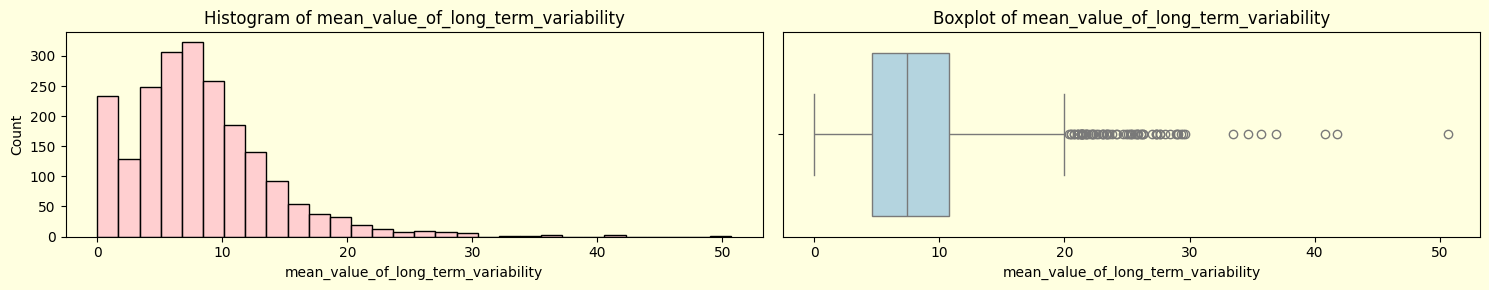

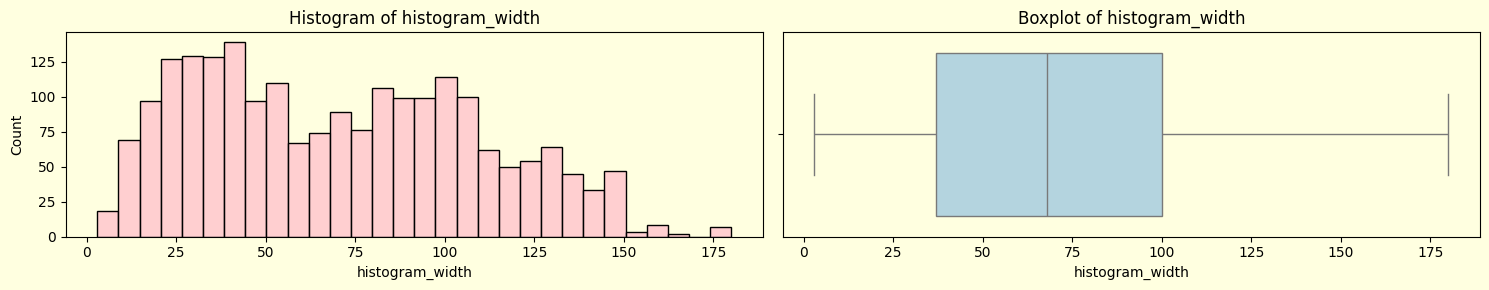

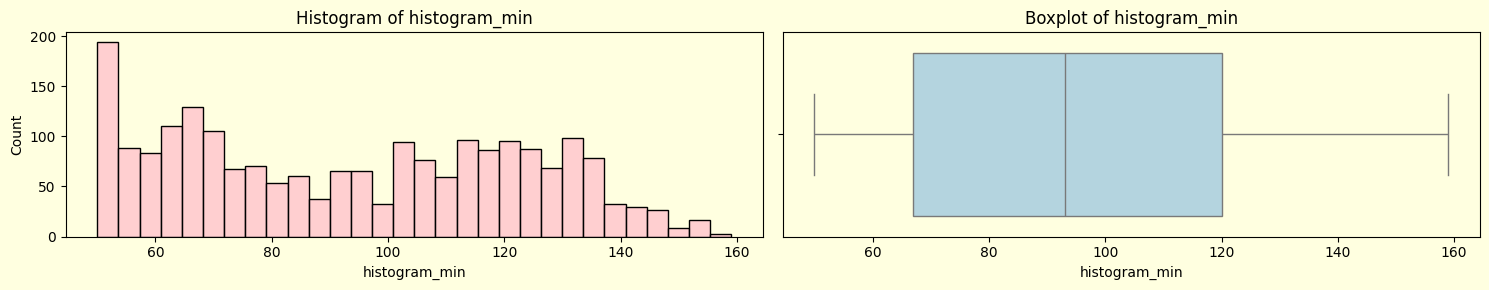

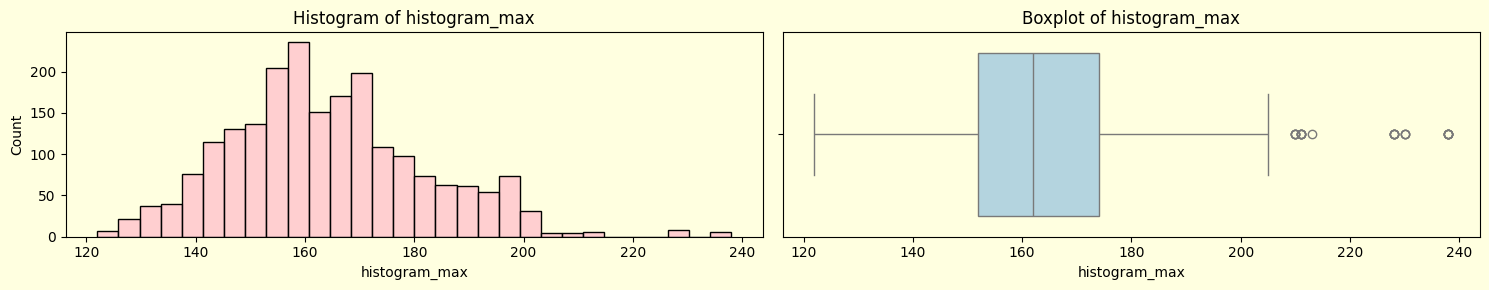

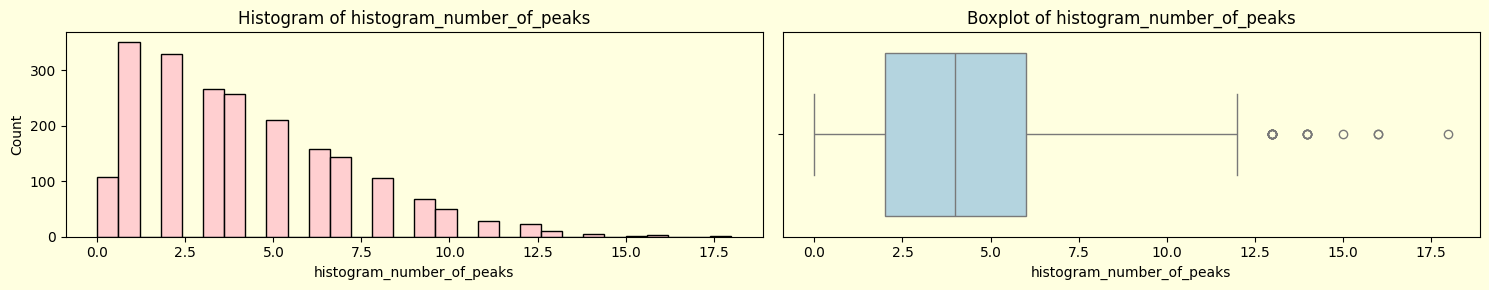

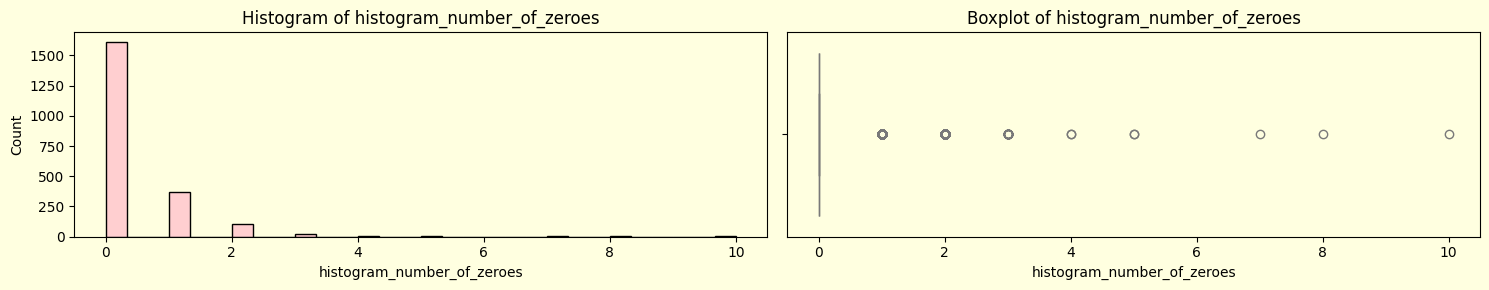

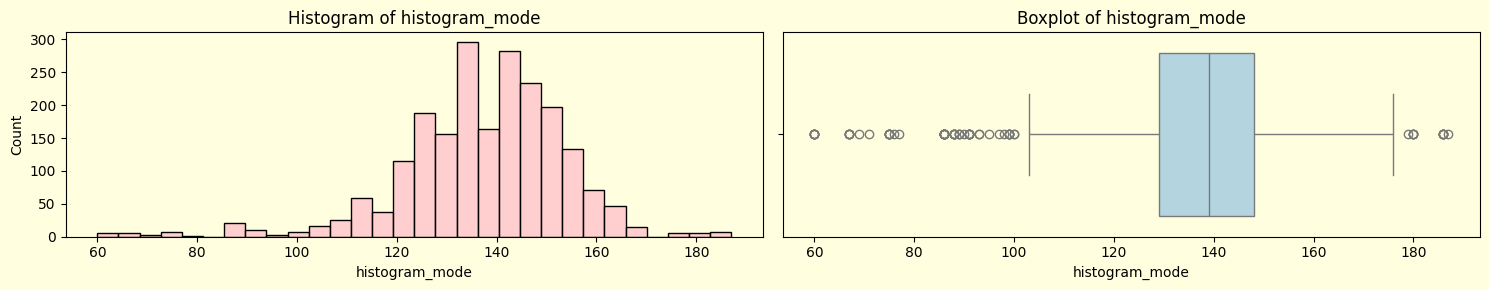

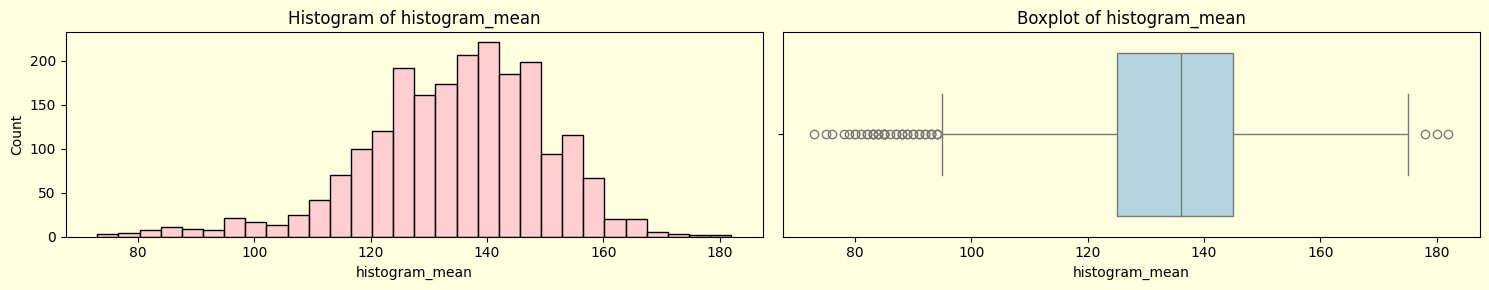

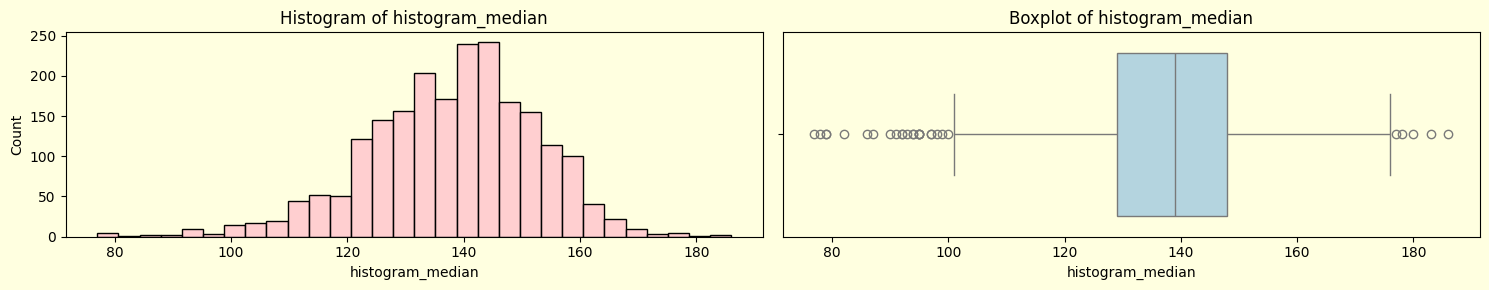

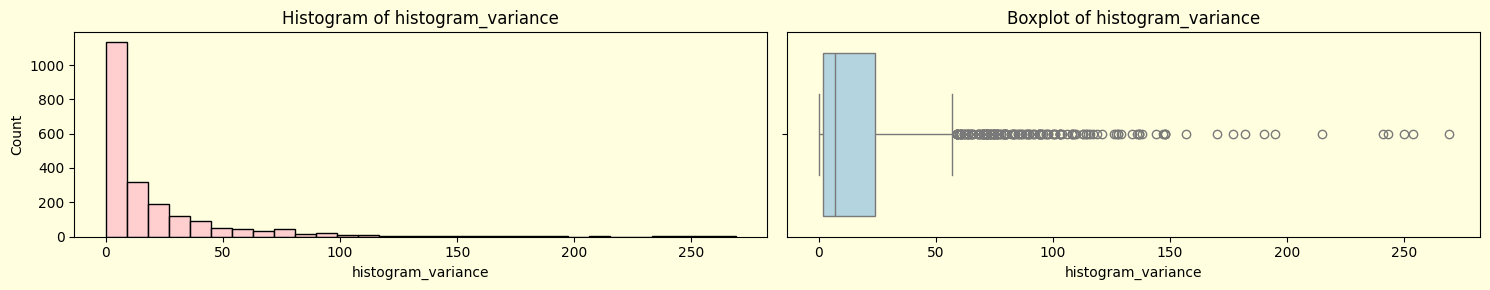

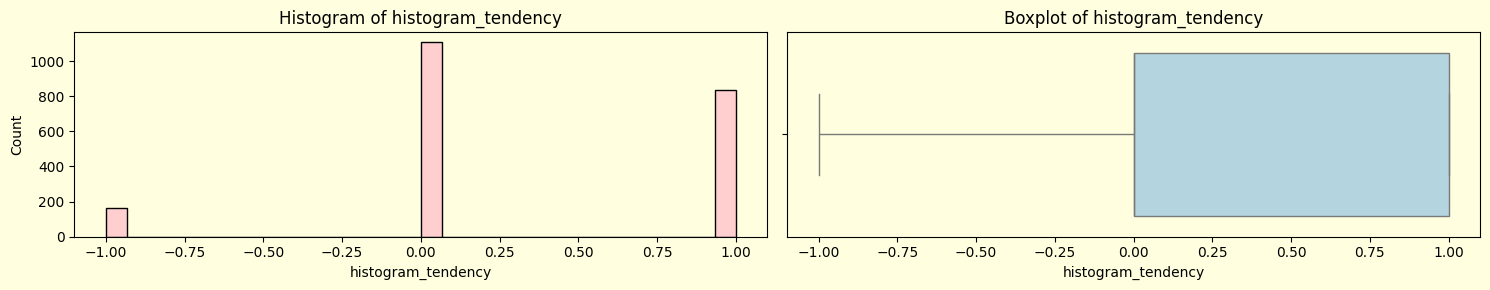

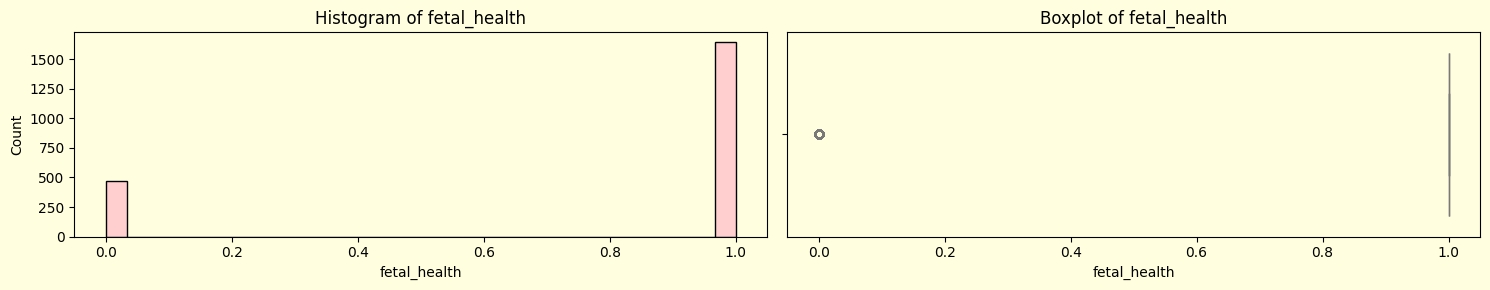

In [112]:
# Check outlier and distribution
# num_data = data.drop(columns="")
def check_distribution_outliers(dataframe, numerical):
    for col in numerical:
        if (col == 'Class'): continue
        plt.figure(figsize=(15, 3))

        plt.subplot(1, 2, 1)
        sns.histplot(dataframe[col], bins=30, color = "pink")
        plt.title(f'Histogram of {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=dataframe[col], color = "lightblue")
        plt.title(f'Boxplot of {col}')

        plt.tight_layout()
        plt.show()

check_distribution_outliers(data[data.columns],data)

## Multicollinearity

In [113]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
X = data.copy()
X = X.dropna()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif_data)

                                              Feature          VIF
0                                      baseline value     6.727684
1                                       accelerations     2.922765
2                                      fetal_movement     1.139015
3                                uterine_contractions     1.318652
4                                 light_decelerations     3.449336
5                                severe_decelerations     1.142684
6                            prolongued_decelerations     2.919257
7                     abnormal_short_term_variability     2.041917
8                mean_value_of_short_term_variability     2.972440
9   percentage_of_time_with_abnormal_long_term_var...     2.104923
10                mean_value_of_long_term_variability     2.081297
11                                    histogram_width  9385.665470
12                                      histogram_min  5204.363027
13                                      histogram_max  2049.76

We observe that some features in the dataset exhibit very high multicollinearity, particularly the histogram-related features such as histogram_width, histogram_min, histogram_max, histogram_mean, and histogram_median. This suggests that these features contain redundant information and are likely overlapping in the patterns they represent.

High multicollinearity can negatively affect the model's performance by making it difficult to determine the individual effect of correlated variables. It can also increase the risk of overfitting and reduce the model's interpretability.

As seen above, the VIF values for some histogram features are extremely high (well above the commonly used threshold of 10), confirming multicollinearity concerns. These features may be considered for dimensionality reduction or removal in the preprocessing stage to improve model performance and reliability.

In [114]:
anova_results = {}
for col in data.columns:
    groups = [group[col].dropna().values for name, group in data.groupby('fetal_health')]
    stat, pval = f_oneway(*groups)
    anova_results[col] = {'p-value': pval}

anova_results

c:\Users\lenovo\anaconda3\envs\py310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


{'baseline value': {'p-value': 2.503367092563335e-31},
 'accelerations': {'p-value': 1.1547222993910796e-79},
 'fetal_movement': {'p-value': 0.0051942087262612695},
 'uterine_contractions': {'p-value': 4.654953344151791e-35},
 'light_decelerations': {'p-value': 0.138463421733408},
 'severe_decelerations': {'p-value': 4.731428776300871e-05},
 'prolongued_decelerations': {'p-value': 3.736619186179752e-59},
 'abnormal_short_term_variability': {'p-value': 1.1446917852104246e-128},
 'mean_value_of_short_term_variability': {'p-value': 1.5154044626551564e-21},
 'percentage_of_time_with_abnormal_long_term_variability': {'p-value': 4.477011357856203e-125},
 'mean_value_of_long_term_variability': {'p-value': 2.394091258316509e-15},
 'histogram_width': {'p-value': 4.9386195569361235e-11},
 'histogram_min': {'p-value': 2.562047658026274e-13},
 'histogram_max': {'p-value': 0.02506666481430303},
 'histogram_number_of_peaks': {'p-value': 0.006536944801838365},
 'histogram_number_of_zeroes': {'p-value

After we get the anova result we can see that these features need to be treated well: <br>
- Histogram Width, Min, Max, Median, Mode : This feature is redundant but still relevant from the ANOVA p-value result --> consider PCA
- Histogram Number of Zeroes : Not significant from ANOVA, remove
- light_decelerations : Not significant, remove

While the other are just good


# Data preprocessing

## Dropping the useless data

In [115]:
data.drop(columns=["light_decelerations", "histogram_number_of_zeroes"], inplace=True)

## PCA the histogram features

In [116]:
histogram_features = [
    'histogram_width',
    'histogram_min',
    'histogram_max',
    'histogram_mean',
    'histogram_median',
    'histogram_mode'
]

In [117]:
X_hist = data[histogram_features]
X_other = data.drop(columns=histogram_features + ['fetal_health'])  # exclude target
scaler = MinMaxScaler()
X_hist_scaled = scaler.fit_transform(X_hist)

pca = PCA(n_components=2)
X_hist_pca = pca.fit_transform(X_hist_scaled)

# Convert PCA result to DataFrame
pca_df = pd.DataFrame(X_hist_pca, columns=['hist_pca1', 'hist_pca2'])

In [118]:
x = pd.concat([X_other.reset_index(drop=True), pca_df], axis=1)
y = data['fetal_health'].values

Now the data is clean with the features that is associated with the target values only and reducing the multiconllinearity

## Use t-SNE to see the data distribution
Using dimensionality reduction allows us to see the distribution of the data with the top n component with the most information of the dataset

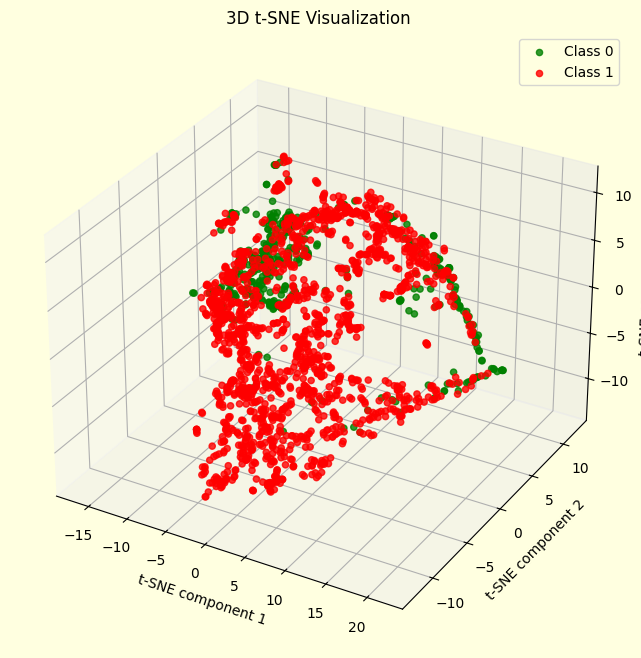

In [119]:
def tsne_plot_3d(x1, y1):
    tsne = TSNE(n_components=3, random_state=0)
    X_t = tsne.fit_transform(x1)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    idx_0 = np.where(y1 == 0)[0]
    idx_1 = np.where(y1 == 1)[0]
    idx_2 = np.where(y1 == 2)[0]  # if there's a third class in fetal_health

    ax.scatter(X_t[idx_0, 0], X_t[idx_0, 1], X_t[idx_0, 2], c='g', label='Class 0', alpha=0.8)
    ax.scatter(X_t[idx_1, 0], X_t[idx_1, 1], X_t[idx_1, 2], c='r', label='Class 1', alpha=0.8)
    if len(idx_2) > 0:
        ax.scatter(X_t[idx_2, 0], X_t[idx_2, 1], X_t[idx_2, 2], c='b', label='Class 2', alpha=0.8)

    ax.set_title("3D t-SNE Visualization")
    ax.set_xlabel("t-SNE component 1")
    ax.set_ylabel("t-SNE component 2")
    ax.set_zlabel("t-SNE component 3")
    ax.legend(loc='best')
    plt.show()


tsne_plot_3d(x, y)

From the above graph we can observe that there are many Pathological (minority) fetal health which are very close to healthy fetal, thus are difficult to accurately classify from a model.

## Splitting and Scaling the data

The data here is not split by making it into train and test data, but instead splitting it to `healthy` data and `patho` data. This step is done because we would be needing only the healthy data to train the autoencoder. Scaling is also done with MinMaxScaler to ensure the features valeus to be 0-1

In [120]:
scaler = MinMaxScaler()

x_healthy, x_patho = x[y == 1], x[y != 1]
x_healthy = scaler.fit_transform(x_healthy.values)
x_patho = scaler.transform(x_patho.values)

# Modelling

The autoencoder used in this project follows a basic hourglass, or butterfly, architecture, consisting of three main components: the `Encoder`, `Latent Space`, and `Decoder` blocks. The Encoder is responsible for compressing the input data into a more compact and informative representation. This compressed representation is stored in the Latent Space, which captures the most essential features of the data. The Decoder then reconstructs the original input from the information contained in the latent space, aiming to produce an output as close as possible to the original input.

## AutoEncoder

In [121]:
input_layer = Input(shape=(x.shape[1],))

# Encoder
encoder = Dense(256, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Dense(128, activation="relu")(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Dense(64, activation="relu")(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Dense(32, activation="relu")(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

latent = Dense(16, activation="relu")(encoder)
latent = BatchNormalization()(latent)
latent = Dropout(0.2)(latent)

decoder = Dense(32, activation="relu")(latent)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)

decoder = Dense(64, activation="relu")(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)

decoder = Dense(128, activation="relu")(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)

decoder = Dense(256, activation="relu")(decoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)

# Output layer
output_layer = Dense(x.shape[1], activation='sigmoid')(decoder)

# Model
ae = Model(input_layer, output_layer)
ae.compile(optimizer="adam", loss="mae")
ae.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_30 (Dense)            (None, 256)               4096      
                                                                 
 batch_normalization_27 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_28 (Bat  (None, 128)              512       
 chNormalization)                                          

### Training Autoencoder

Some callbacks are used to monitor the training process

In [122]:
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("autoencoder.h5", monitor='val_loss', save_best_only=True, mode='min')
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
callbacks = [early, model_checkpoint, reducelr]

The autoencoder model is trained solely on x_healthy data, allowing it to learn and reconstruct only the normal patterns found in healthy samples. This training ensures that the model captures the latent representations specific to healthy data. During inference, both healthy and pathogen data are passed through the model. Since the autoencoder has never seen pathogen data, it will struggle to reconstruct it accurately, leading to higher reconstruction errors. These errors are then used to classify inputs as either healthy (low error) or anomalous/pathogenic (high error)

In [123]:
history = ae.fit(x_healthy, x_healthy, 
                callbacks = callbacks,
                batch_size = 32, epochs = 100, 
                shuffle = True, validation_split = 0.20)

Epoch 1/100
42/42 [==============================] - 4s 34ms/step - loss: 0.3413 - val_loss: 0.2338 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - 1s 16ms/step - loss: 0.2804 - val_loss: 0.1618 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - 1s 32ms/step - loss: 0.2231 - val_loss: 0.1441 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - 1s 34ms/step - loss: 0.1788 - val_loss: 0.1386 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - 1s 18ms/step - loss: 0.1481 - val_loss: 0.1350 - lr: 0.0010
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 0.1277 - val_loss: 0.1325 - lr: 0.0010
Epoch 7/100
42/42 [==============================] - 1s 21ms/step - loss: 0.1170 - val_loss: 0.1249 - lr: 0.0010
Epoch 8/100
42/42 [==============================] - 1s 18ms/step - loss: 0.1117 - val_loss: 0.1149 - lr: 0.0010
Epoch 9/100
42/42 [==============================] - 1s 26ms/step - loss: 0.1087 - val_loss: 0.1

## Taking Latent Respresentation

Next, we extract the weights from the trained autoencoder, specifically from the input layer up to the latent layer, effectively isolating the encoder. This encoder is then used as a feature extractor to transform input data into its latent representation. These latent vectors serve as inputs to a separate prediction model. If the resulting latent representation is close to the patterns learned from healthy data, it is classified as 'healthy'. Otherwise, if the latent representation appears unfamiliar or significantly different—i.e., the model cannot encode it well—it is classified as 'pathogenic'.

In [124]:
hidden_representation = Model(inputs=ae.input, outputs=latent)
hidden_representation.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_30 (Dense)            (None, 256)               4096      
                                                                 
 batch_normalization_27 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_28 (Bat  (None, 128)              512       
 chNormalization)                                          

In [125]:
norm_hid_rep = hidden_representation.predict(x_healthy)
patho_hid_rep = hidden_representation.predict(x_patho)

15/15 [==============================] - 0s 2ms/step


These rep_x and rep_y will be the representative of the features that has been changed to latent space by the autoencoder and will act as the data for the machine learning algprithm to predict

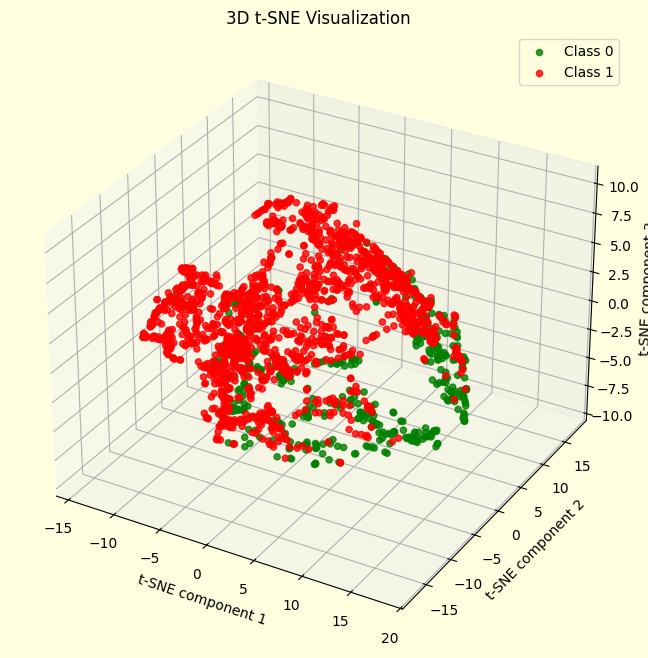

In [126]:
rep_x = np.concatenate([patho_hid_rep, norm_hid_rep], axis=0)
rep_y = np.concatenate([np.zeros(len(patho_hid_rep)), np.ones(len(norm_hid_rep))])
tsne_plot_3d(rep_x, rep_y)

The 3D t-SNE plot of the latent representation shows a much clearer separation compared to the original data. This is a promising indication that the autoencoder has successfully learned meaningful features, potentially leading to a high-performing anomaly detection model.

In [127]:
recon_healthy = ae.predict(x_healthy)
recon_patho = ae.predict(x_patho)
mse_healthy = np.mean(np.square(x_healthy - recon_healthy), axis=1)
mse_patho = np.mean(np.square(x_patho - recon_patho), axis=1)

15/15 [==============================] - 0s 8ms/step


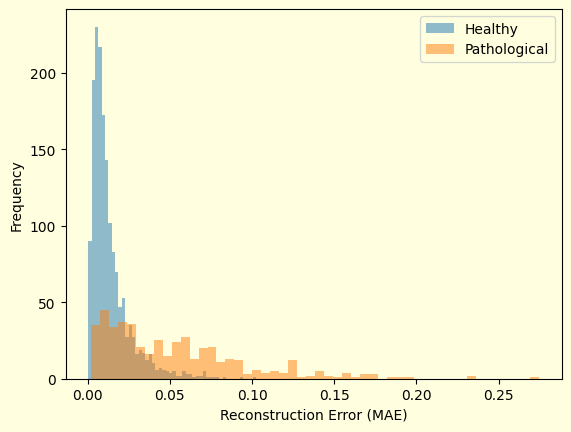

In [128]:
plt.hist(mse_healthy, bins=50, alpha=0.5, label='Healthy')
plt.hist(mse_patho, bins=50, alpha=0.5, label='Pathological')
plt.xlabel('Reconstruction Error (MAE)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Making Prediction

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=42)

For the Machine Learning Model, I make a dictionaries of model that we can try to see their performance to our data and then we will pick the one with the best performance. <br>
Some of the model that will be used are :
- Logistic Regression
- Random Forest
- Decision Tree
- SVM Classifier with Linear and RBF kernel
- XGBoost
- KNN Classifier
- Naive Bayes, and
- AdaBoost

In [151]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVC (Linear)": SVC(kernel='linear'),
    "SVC (RBF)": SVC(kernel='rbf'),
    "XGBoost": XGBClassifier(scale_pos_weight=len(train_y[train_y == 0]) / len(train_y[train_y == 1])),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier()
}

Sample weight is used to train the model that support it, and for some model that dont, we will not use it and just train it with the data only. This apporach is done to tackle the challenge of class imbalance too

In [152]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train_y
)

for name, model in models.items():
    try:
        model.fit(train_x, train_y, sample_weight=sample_weights)
    except TypeError:
        print(f"{name} does not support sample weights. Fitting without sample weights.")
        model.fit(train_x, train_y)

    preds = model.predict(val_x)
    print(f"\n{name}:\n")
    print(classification_report(val_y, preds, zero_division=0))


Logistic Regression:

              precision    recall  f1-score   support

         0.0       0.63      0.86      0.73       128
         1.0       0.95      0.84      0.89       401

    accuracy                           0.84       529
   macro avg       0.79      0.85      0.81       529
weighted avg       0.87      0.84      0.85       529


Random Forest:

              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80       128
         1.0       0.92      0.97      0.94       401

    accuracy                           0.91       529
   macro avg       0.90      0.85      0.87       529
weighted avg       0.91      0.91      0.91       529


Decision Tree:

              precision    recall  f1-score   support

         0.0       0.77      0.69      0.73       128
         1.0       0.90      0.94      0.92       401

    accuracy                           0.88       529
   macro avg       0.84      0.81      0.82       529
weighted avg     

From here we can see that the best model for the **Anomaly Detection** case is XGBoost because it's balance towards the minority class by being able to get decent recall for the anomaly data, getting the best F1-score among all the models

# Evaluation

In [153]:
model = XGBClassifier(scale_pos_weight=len(train_y[train_y == 0]) / len(train_y[train_y == 1]))
model.fit(train_x, train_y)
pred_y = model.predict(val_x)

## Classification Report

In [154]:
print ("Classification Report: ")
print (classification_report(val_y, pred_y))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       128
         1.0       0.93      0.94      0.94       401

    accuracy                           0.91       529
   macro avg       0.87      0.87      0.87       529
weighted avg       0.90      0.91      0.90       529

Accuracy Score:  0.9054820415879017


## Confusion Matrix

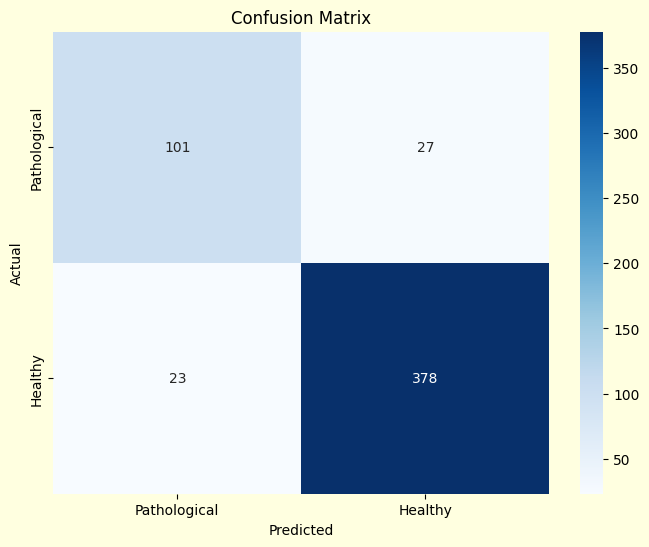

In [145]:
cm = confusion_matrix(val_y, pred_y)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pathological', 'Healthy'], yticklabels=['Pathological', 'Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

From the confusion matrix, we can observe that the model demonstrates a moderate ability to detect anomalies, such as pathological fetal cases. While it shows strong performance in identifying healthy cases, it still requires further development to improve its reliability in detecting anomalies.

Specifically, the model correctly identified 101 out of 128 actual pathological cases and 378 out of 401 actual healthy cases. Although it performs well in classifying healthy individuals (high true negatives), it misclassified 27 pathological cases as healthy (false negatives) and 23 healthy cases as pathological (false positives). Reducing these misclassifications is crucial, especially for false negatives, as missing pathological cases could have serious real-world consequences.

## Threshold Tuning

In [143]:
full_probabilities = model.predict_proba(val_x)

positive_probs = full_probabilities[:, 1]
best_threshold = 0.5
best_f1 = 0.0

for threshold in np.arange(0.1, 1.0, 0.05):
    preds = (positive_probs >= threshold).astype(int)
    current_f1 = f1_score(val_y, preds)
    print(f"Threshold: {threshold:.2f}, F1-Score: {current_f1:.10f}")
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")


Threshold: 0.10, F1-Score: 0.9254437870
Threshold: 0.15, F1-Score: 0.9354066986
Threshold: 0.20, F1-Score: 0.9314079422
Threshold: 0.25, F1-Score: 0.9312424608
Threshold: 0.30, F1-Score: 0.9271844660
Threshold: 0.35, F1-Score: 0.9304029304
Threshold: 0.40, F1-Score: 0.9325153374
Threshold: 0.45, F1-Score: 0.9371146732
Threshold: 0.50, F1-Score: 0.9379652605
Threshold: 0.55, F1-Score: 0.9364881694
Threshold: 0.60, F1-Score: 0.9373433584
Threshold: 0.65, F1-Score: 0.9358490566
Threshold: 0.70, F1-Score: 0.9318181818
Threshold: 0.75, F1-Score: 0.9248407643
Threshold: 0.80, F1-Score: 0.9076723017
Threshold: 0.85, F1-Score: 0.9045751634
Threshold: 0.90, F1-Score: 0.8921438083
Threshold: 0.95, F1-Score: 0.8751714678
Best Threshold: 0.50
Best F1-Score: 0.9380


Threshold tuning was performed to evaluate whether adjusting the classification threshold could improve the model’s ability to detect anomalies. By default, most classifiers use a threshold of 0.50 (50%), meaning a sample is classified as positive if the predicted probability exceeds 0.50. The goal of tuning is to potentially improve recall for anomalies (e.g., pathological cases) by shifting this threshold.

However, based on the evaluation results, the optimal threshold remained at 0.50, indicating that the default threshold already yields the best performance in this case. Therefore, additional threshold tuning does not provide any benefit for improving anomaly detection in this scenario.

## ROC-AUC

In [132]:
probs = model.predict_proba(val_x)[:, 1]

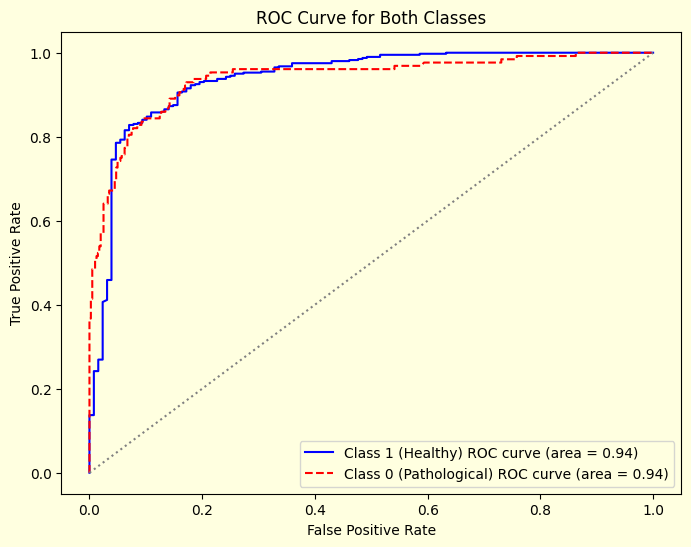

In [133]:
# ROC curve for class 1 (healthy)
fpr_1, tpr_1, _ = roc_curve(val_y, probs)
roc_auc_1 = auc(fpr_1, tpr_1)

# ROC curve for class 0 (pathological)
fpr_0, tpr_0, _ = roc_curve(1 - val_y, 1 - probs)
roc_auc_0 = auc(fpr_0, tpr_0)

plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, color='blue', label=f'Class 1 (Healthy) ROC curve (area = {roc_auc_1:.2f})')
plt.plot(fpr_0, tpr_0, color='red', linestyle='--', label=f'Class 0 (Pathological) ROC curve (area = {roc_auc_0:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Both Classes')
plt.legend(loc='lower right')
plt.show()

In [134]:
scores = cross_val_score(model, rep_x, rep_y, cv=10, scoring='roc_auc')
print("Cross-validated AUC:", scores.mean(), "±", scores.std())

Cross-validated AUC: 0.9041456509090361 ± 0.07089500151098


The ROC AUC scores for both the normal (Class 1) and anomaly (Class 0) classes are 0.94, indicating that the model has a strong ability to distinguish between the two classes. This is further supported by the cross-validated AUC score of 0.904 ± 0.071, showing that the model maintains consistent performance across different data splits. These results suggest that the model is robust and capable of generalizing well, making it a reliable tool for detecting anomalies in the dataset.

# Conclusion


The model demonstrates robust and clinically relevant performance in classifying fetal health conditions:

- ROC AUC Score of 0.94 for both Class 0 (pathological) and Class 1 (non-pathological) indicates excellent separation between high-risk and normal cases.
- A cross-validated AUC of 0.904 ± 0.071 confirms the model’s ability to generalize reliably across different data splits, with low variance.
- The classification report shows strong performance on the critical pathological class (Class 0), with precision of 0.81, recall of 0.79, and an F1-score of 0.80, suggesting the model successfully detects most at-risk fetuses while minimizing false positives.
- Class 1 (non-pathological) achieves even higher metrics (precision: 0.93, recall: 0.94, F1-score: 0.94), maintaining overall balance in performance.
- An accuracy of 90.5%, paired with a macro F1-score of 0.87, reflects the model’s effectiveness in handling class imbalance, critical in medical applications.
- The confusion matrix shows 101 true positives for the pathological class and only 27 false negatives, a favorable outcome when early intervention is key.

Conclusion:
The model is well-suited for real-world deployment in fetal health screening, offering high sensitivity to pathological cases while maintaining overall reliability and generalization, helping clinicians make timely and accurate decisions.

# Future Work

- Optimize Autoencoder Depth: Explore shallower autoencoder architectures that maintain strong reconstruction capabilities while reducing model complexity and training time.

- Enhance Class-wise Reconstruction Gap: Adjust the autoencoder to produce more distinct reconstruction errors between classes, especially to improve differentiation between pathological and non-pathological cases.

- Try another Approach of Anomlay Detection

- Experimenting with VAE